## Import Packages

In [ ]:
!pip3 install nltk

In [ ]:
!pip install contractions

In [ ]:
!pip install wordcloud

In [4]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re

import matplotlib.pyplot as plt
import contractions
from collections import Counter
import string
import seaborn as sns
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
from collections import defaultdict

## Load Data

In [5]:
# Read the dataset
train_filename = "./Corona_NLP_train.csv"
test_filename = "./Corona_NLP_test.csv"

train_df = pd.read_csv(train_filename, encoding='latin1') # alternatively encoding='iso-8859-1' or encoding='cp1252'
test_df = pd.read_csv(test_filename, encoding='latin1')

In [6]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


## Statistical Analysis

In [8]:
# Concatonate the test, train datasets for EDA
data = pd.concat([test_df, train_df],ignore_index = True)

test_len = len(test_df)
train_len = len(train_df)
ratio = test_len / (test_len + train_len)

print("Total number of entries: {}".format(len(data)))
print("Total number of entries in the training set: {}".format(len(train_df)))
print("Total number of entries in the test set: {}".format(len(test_df)))
print("Percentage of entries in test set to training set: {:.1f}% : {:.1f}%".format(ratio*100, 100-(ratio*100)))

Total number of entries: 44955
Total number of entries in the training set: 41157
Total number of entries in the test set: 3798
Percentage of entries in test set to training set: 8.4% : 91.6%


In [9]:
print("Number of distinct values in each column:")
print(data.nunique())

Number of distinct values in each column:
UserName         44955
ScreenName       44955
Location         13127
TweetAt             44
OriginalTweet    44955
Sentiment            5
dtype: int64


* There are 5 unique sentiments
* Every tweet is unique and written by a different person, of which there are 44,995

In [10]:
print("Number of tweets for each sentiment:")
print(data['Sentiment'].value_counts())

Number of tweets for each sentiment:
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64


In [11]:
print("Number of tweets from each location:")
print(data['Location'].value_counts())

Number of tweets from each location:
United States                   603
London, England                 568
London                          565
New York, NY                    429
Washington, DC                  411
                               ... 
Bethnal Green                     1
York County, SC                   1
Goa                               1
Maz?tl?n                          1
i love you so much || he/him      1
Name: Location, Length: 13127, dtype: int64


In [12]:
# Measuring length of reviews by words
data['tweet_len_by_words'] = data['OriginalTweet'].apply(lambda t: len(t.split()))
min_len_word, max_len_word = data['tweet_len_by_words'].min(), data['tweet_len_by_words'].max()
print("Minimum word length of a tweet: {} \nMaximum word length of a tweet: {}".format(min_len_word, max_len_word))

Minimum word length of a tweet: 1 
Maximum word length of a tweet: 64


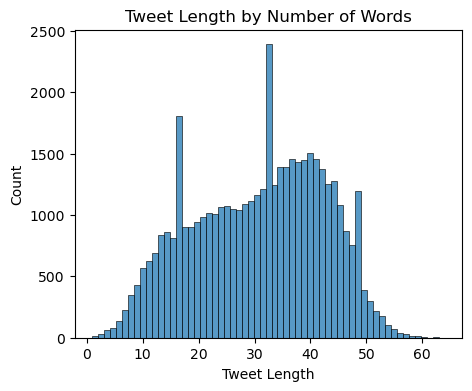

In [13]:
# Histogram of tweets by words
plt.figure(figsize=(5, 4))
sns.histplot(data['tweet_len_by_words'])
plt.title("Tweet Length by Number of Words")
plt.ylabel("Count")
plt.xlabel("Tweet Length")
plt.show()

In [14]:
# Convert sentiment to numerical
data['Sentiment_num'] = data['Sentiment'].replace({'Neutral':2, 'Positive':3,'Extremely Positive':4, 'Extremely Negative':0,'Negative':1}).astype(int)
train_df['Sentiment_num'] = train_df['Sentiment'].replace({'Neutral':2, 'Positive':3,'Extremely Positive':4, 'Extremely Negative':0,'Negative':1}).astype(int)
test_df['Sentiment_num'] = test_df['Sentiment'].replace({'Neutral':2, 'Positive':3,'Extremely Positive':4, 'Extremely Negative':0,'Negative':1}).astype(int)

In [15]:
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,tweet_len_by_words,Sentiment_num
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,23,0
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,30,3
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,13,4
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,37,1
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,26,2


In [16]:
print("Statistics of Sentiment values (converted to numerical) of the entire dataset")
data['Sentiment_num'].describe()

Statistics of Sentiment values (converted to numerical) of the entire dataset


count    44955.000000
mean         2.082549
std          1.301987
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: Sentiment_num, dtype: float64

In [17]:
print("Statistics of Sentiment values (converted to numerical) of the training dataset")
train_df['Sentiment_num'].describe()

Statistics of Sentiment values (converted to numerical) of the training dataset


count    41157.000000
mean         2.092111
std          1.298655
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: Sentiment_num, dtype: float64

In [18]:
print("Statistics of Sentiment values (converted to numerical) of the test dataset")
test_df['Sentiment_num'].describe()

Statistics of Sentiment values (converted to numerical) of the test dataset


count    3798.000000
mean        1.978936
std         1.333342
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: Sentiment_num, dtype: float64

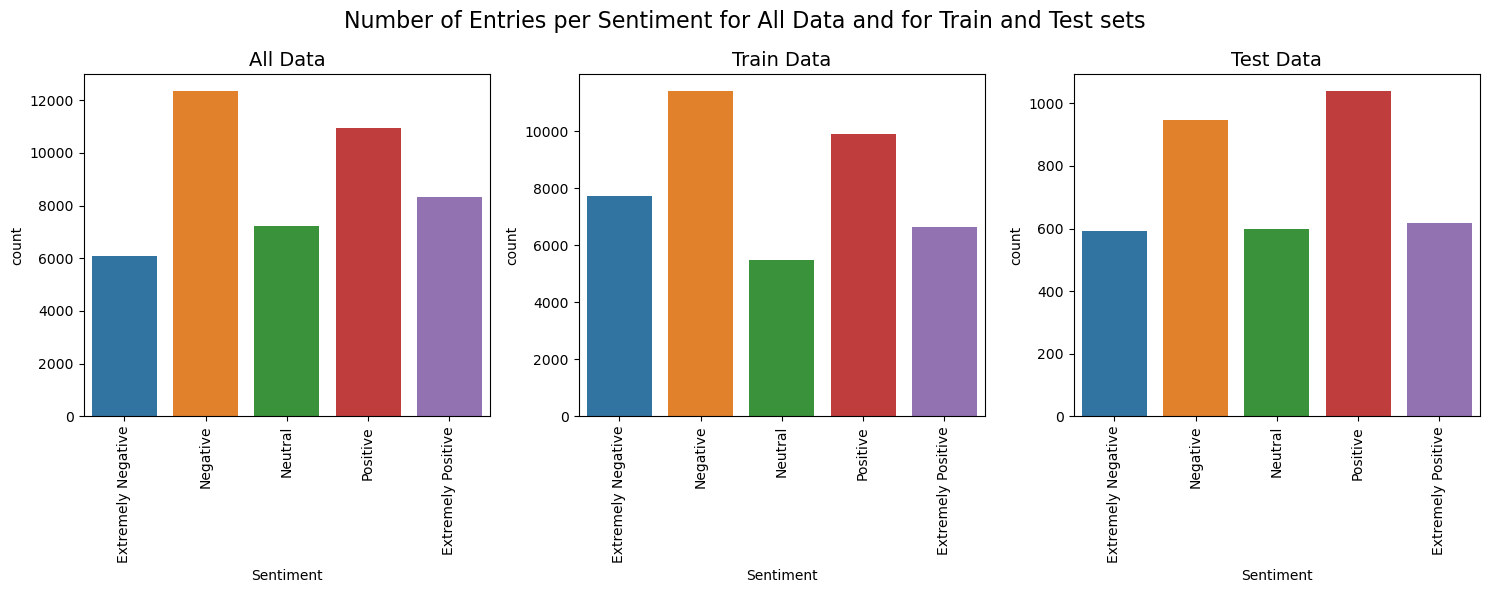

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
class_names = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']

sns.countplot(x='Sentiment', data=data, ax=ax1)
ax1.set_xticklabels(class_names, rotation=90)
ax1.set_title("All Data", fontsize=14)

sns.countplot(x='Sentiment', data=train_df, ax=ax2)
ax2.set_title("Train Data", fontsize=14)
ax2.set_xticklabels(class_names, rotation=90)

sns.countplot(x='Sentiment', data=test_df, ax=ax3)
ax3.set_title("Test Data", fontsize=14)
ax3.set_xticklabels(class_names, rotation=90)

plt.suptitle("Number of Entries per Sentiment for All Data and for Train and Test sets", fontsize=16)

plt.tight_layout()
plt.show()

# EDA

## Pre-Processing

In [20]:
df = train_df.copy()

# Lowercase the reviews to make them consistent
df['lower_case'] = df['OriginalTweet'].apply(lambda x: x.lower())

In [21]:
# Sentiment mapping
sentiment_mapping = {"Extremely Negative": 0, 
                     "Negative": 1,
                     "Neutral": 2,
                     "Positive": 3,
                     "Extremely Positive": 4}

### Replace Unicode & HTML Encoding

In [22]:
def replace_encoding(text):
    rep = {"&amp;": " and ",
               "&lt;": " < ",
               "&gt;": " > "}
    rep = dict((re.escape(k), v) for k, v in rep.items()) 

    pattern = re.compile("|".join(rep.keys()))
    text = pattern.sub(lambda m: rep[re.escape(m.group(0))], text)
    text2 = text
    indexes = []
    for m in re.finditer("â", text):
        indexes.append(m.start())
    indexes.reverse()

    for i in indexes:
        text2 = text2[:i] + "'" + text2[i+2:]
    text3 = text2.replace(" s ", "'s ")
    text4 = text3.replace(" amp ", " and ")
    return text3

In [23]:
df['no_html'] = df['lower_case'].apply(lambda x: replace_encoding(x))

In [24]:
def decode_text(text_unicode):
    # encoding the text to ASCII format
    text_encode = text_unicode.encode(encoding="ascii", errors="ignore")
    # decoding the text
    text_decode = text_encode.decode()
    # cleaning the text to remove extra whitespace 
    clean_text = " ".join([word for word in text_decode.split()])
    return clean_text

In [25]:
df['no_unicode'] = df['no_html'].apply(lambda x: decode_text(x))

In [26]:
print("Original Tweet:")
df['OriginalTweet'].iloc[8809]

Original Tweet:


'Sorted for the #CoronaCrisis. \r\r\n\r\r\n*I didnÂ\x92t panic buy these, theyÂ\x92ve been in the freezer since last summer.\r\r\n\r\r\n**I probably canÂ\x92t have them anyway because IÂ\x92m diabetic. \r\r\n\r\r\n***stop buying all the food I need to not get ill from diabetes. https://t.co/gZpvwhmxVm'

In [27]:
print("Original Tweet:")
df['no_unicode'].iloc[8809]

Original Tweet:


"sorted for the #coronacrisis. *i didn't panic buy these, they've been in the freezer since last summer. **i probably can't have them anyway because i'm diabetic. ***stop buying all the food i need to not get ill from diabetes. https://t.co/gzpvwhmxvm"

### Remove Contractions

For example:
* I'll `->` I will
* Isn't `->` Is not
* Didn't `->` Did not

In [28]:
# Replace contractions
def expand_contractions(text):
    expanded_words = []
    for word in text.split():
        expanded_words.append(contractions.fix(word))
    expanded_text = ' '.join(expanded_words)
    return expanded_text

df['no_contractions'] = df['no_unicode'].apply(lambda x: expand_contractions(x))

In [29]:
print("Contractions Removed:")
df['no_contractions'].iloc[8809]

Contractions Removed:


'sorted for the #coronacrisis. *i did not panic buy these, they have been in the freezer since last summer. **i probably cannot have them anyway because i am diabetic. ***stop buying all the food i need to not get ill from diabetes. https://t.co/gzpvwhmxvm'

### Remove numbers, links, tags and punctuation

In [30]:
# Extract hashtags
def get_hashtags(text):
    hashtags = re.findall("#([a-zA-Z0-9_]{1,50})", text)
    return hashtags

df['hashtags'] = df['no_contractions'].apply(lambda x: get_hashtags(x))

In [31]:
# Remove hashtags
def remove_hashtags(text):
    clean_tweet = re.sub("#[A-Za-z0-9_]+","", text)
    return clean_tweet

df['no_hashtags'] = df['no_contractions'].apply(lambda x: remove_hashtags(x))

In [32]:
# Replace standalone asterisks with blank space
def replace_asterisks(text):
    new_text = text.replace(" * ", " ")
    new_text_1 = new_text.replace(" ** ", " ")
    new_text_2 = new_text_1.replace(" *** ", " ")
    return new_text_2

df['no_asterisks'] = df['no_hashtags'].apply(lambda x: replace_asterisks(x))

### Clean the Hashtag Column: Remove Numbers and Punctuation

In [33]:
# Remove punctuation
def remove_punc_nums(text):
    new_list = [''.join(char for char in item if char not in string.punctuation and char not in string.digits) for item in text]
    new_list = ['covid' if x=='coronavirus' else x for x in new_list]
    return new_list

df['hashtags'] = df['hashtags'].apply(lambda x: remove_punc_nums(x))

### Replace Swearwords

In [34]:
def replace_swearwords(text):
    rep = {"f***ing": "swearword",
        "f**king": "swearword",
        "f*cking": "swearword",
        "f*ck": "swearword",
        "f**k": "swearword",
        "f*****g": "swearword",
        "f****n": "swearword",
        "f****d": "swearword",
        "f***": "swearword",
        "b*****ds": "swearword",
        "fu****": "swearword",
        "s***": "swearword",
        "sh*t": "swearword",
        "fucking": "swearword",
        "fucker": "swearword",
        "fucked": "swearword",
        "fuck": "swearword",
        "shit": "swearword",
        "*******": "swearword",
        "******": "swearword",
        "*****": "swearword",
        "****": "swearword"}
    rep = dict((re.escape(k), v) for k, v in rep.items()) 
    pattern = re.compile("|".join(rep.keys()))
    text = pattern.sub(lambda m: rep[re.escape(m.group(0))], text)
    return text

In [35]:
df['no_swearwords'] = df['no_asterisks'].apply(lambda x: replace_swearwords(x))

In [36]:
def replace_slang(text):
    rep = {" er ": " emergency room ",
         " omg ": " oh my god ",
         " fyi ": " for your information ",
         " y ": " why ",
         " btwn ": " between ",
         " jk ": " joke ",
         " dm ": " direct message ",
           " y ": " why "
            }
    rep = dict((re.escape(k), v) for k, v in rep.items()) 
    pattern = re.compile("|".join(rep.keys()))
    text = pattern.sub(lambda m: rep[re.escape(m.group(0))], text)
    return text

df['no_slang'] = df['no_swearwords'].apply(lambda x: replace_slang(x))

### Remove URLS, Tags, Punctuation and Numbers

In [37]:
# Extract links
def remove_urls(text):
    new_text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    return new_text

def remove_tags(text):
    char = '@'
    new_text = ' '.join(filter(lambda word: not word.startswith(char), text.split()))
    return new_text

# Remove punctuation
def remove_punctuation(text):
    # new_text = text.replace("&amp;", ' and ')
    # new_text_1 = new_text.replace("&gt;", " ")
    new_text_2 = text.replace("/", ' ')
    new_text_3 = new_text_2.translate(str.maketrans('', '', string.punctuation))
    return new_text_3

# remove numbers
def remove_numbers(text):
    new_text = text.translate(str.maketrans('', '', string.digits))
    return new_text

df['filtered_text'] = df['no_slang'].apply(lambda x: remove_urls(x))
df['filtered_text'] = df['filtered_text'].apply(lambda x: remove_tags(x))
df['filtered_text'] = df['filtered_text'].apply(lambda x: remove_punctuation(x))
df['filtered_text'] = df['filtered_text'].apply(lambda x: remove_numbers(x))

### Lemmatize

In [38]:
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

def lem(text):
    new_text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    return new_text

df['filtered_text'] = df['filtered_text'].apply(lambda x: lem(x))

[nltk_data] Downloading package omw-1.4 to /home/jupyter/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Replace errors in lemmatizing:
* ha `->` has
* wa `->` was

In [39]:
def replace_lem(text):
    slang = {" ha ": " has ",
             " wa ": " was "
            }
    rep = dict((re.escape(k), v) for k, v in slang.items()) 
    #Python 3 renamed dict.iteritems to dict.items so use rep.items() for latest versions
    pattern = re.compile("|".join(rep.keys()))
    text = pattern.sub(lambda m: rep[re.escape(m.group(0))], text)
    return text

df['filtered_text'] = df['filtered_text'].apply(lambda x: replace_lem(x))

## Most Common Words

In [40]:
# Get stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
corpus = []
new = df['filtered_text'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

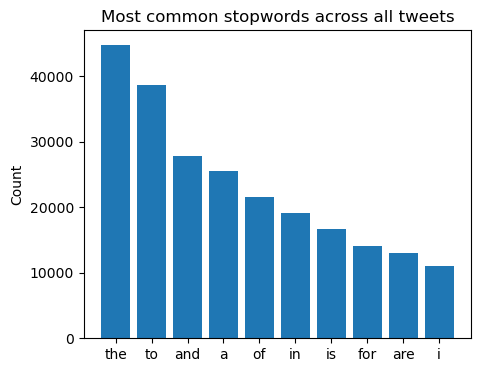

In [42]:
sorted_dic = sorted(dic.items(), key=lambda x:x[1], reverse=True)

x, y = zip(*sorted_dic)

plt.figure(figsize=(5, 4))
plt.bar(x[:10], y[:10])
plt.title("Most common stopwords across all tweets")
plt.ylabel("Count")
plt.show()

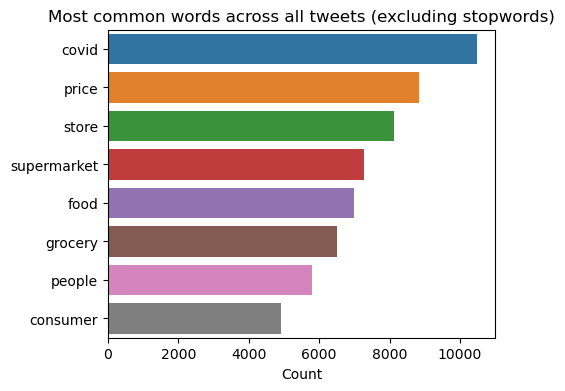

In [43]:
# inspect which words other than these stopwords occur frequently
counter = Counter(corpus)
most = counter.most_common()

x, y = [], []
for word, count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

plt.figure(figsize=(5, 4))
sns.barplot(x=y, y=x)
plt.title("Most common words across all tweets (excluding stopwords)")
plt.xlabel("Count")
plt.show()

### Create Column with no Stopwords

In [44]:
df['no_stopwords'] = df['filtered_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

## Most Common Words by Sentiment

In [45]:
def get_common_words(sentiment):
    corpus = []
    sub_df = df[df['Sentiment'] == sentiment]
    new = sub_df['no_stopwords'].str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1
        
    sorted_dic = sorted(dic.items(), key=lambda x:x[1], reverse=True)

    # x, y = zip(*sorted_dic)

    # inspect which words other than these stopwords occur frequently
    counter = Counter(corpus)
    most = counter.most_common()

    x, y = [], []
    for word, count in most[:40]:
        # if (word not in stop):
        x.append(word)
        y.append(count)
    return x, y

In [46]:
sentiment_list = list(sentiment_mapping.keys())

x = []
y = []

for s in sentiment_list:
    x_val, y_val = get_common_words(s)
    x.append(x_val)
    y.append(y_val)

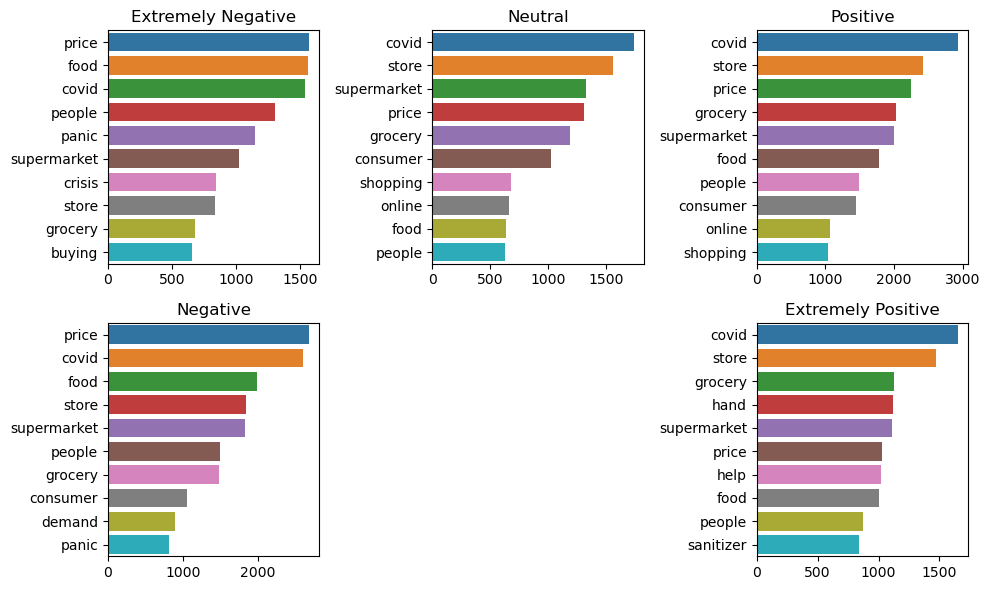

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes[1, 1].set_visible(False)

range = 10

sns.barplot(y=x[0][:range], x=y[0][:range], ax=axes[0, 0])
axes[0, 0].title.set_text(sentiment_list[0])
sns.barplot(y=x[1][:range], x=y[1][:range], ax=axes[1,0])
axes[1, 0].title.set_text(sentiment_list[1])

sns.barplot(y=x[2][:range], x=y[2][:range], ax=axes[0,1])
axes[0, 1].title.set_text(sentiment_list[2])

sns.barplot(y=x[3][:range], x=y[3][:range], ax=axes[0, 2])
axes[0, 2].title.set_text(sentiment_list[3])
sns.barplot(y=x[4][:range], x=y[4][:range], ax=axes[1,2])
axes[1, 2].title.set_text(sentiment_list[4])

plt.tight_layout()

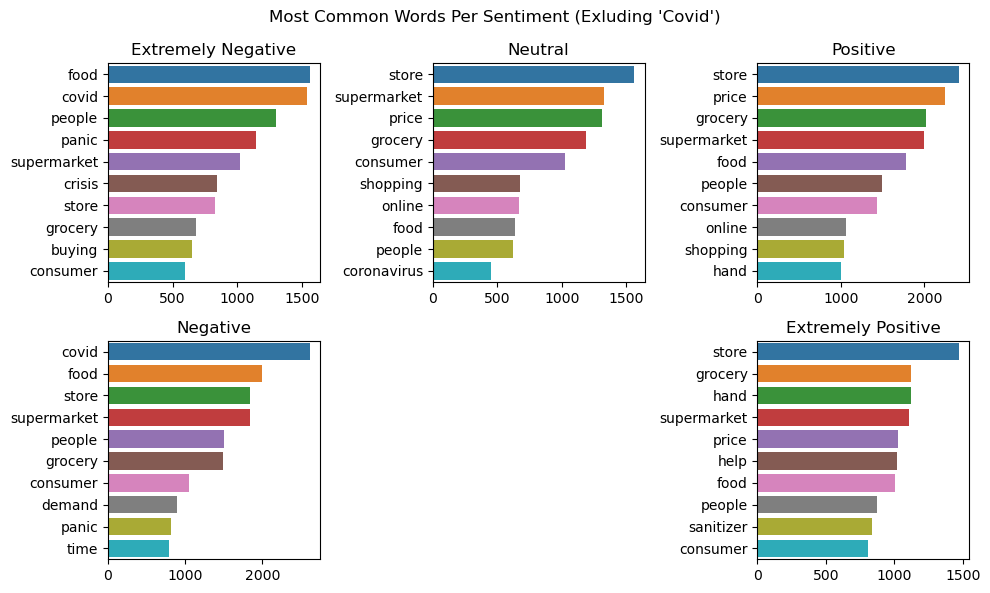

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes[1, 1].set_visible(False)

min_r = 1
max_r = 11

sns.barplot(y=x[0][min_r:max_r], x=y[0][min_r:max_r], ax=axes[0, 0])
axes[0, 0].title.set_text(sentiment_list[0])
sns.barplot(y=x[1][min_r:max_r], x=y[1][min_r:max_r], ax=axes[1,0])
axes[1, 0].title.set_text(sentiment_list[1])

sns.barplot(y=x[2][min_r:max_r], x=y[2][min_r:max_r], ax=axes[0,1])
axes[0, 1].title.set_text(sentiment_list[2])

sns.barplot(y=x[3][min_r:max_r], x=y[3][min_r:max_r], ax=axes[0, 2])
axes[0, 2].title.set_text(sentiment_list[3])
sns.barplot(y=x[4][min_r:max_r], x=y[4][min_r:max_r], ax=axes[1,2])
axes[1, 2].title.set_text(sentiment_list[4])

fig.suptitle("Most Common Words Per Sentiment (Exluding 'Covid')")

plt.tight_layout()

## N-Grams

In [49]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

In [50]:
corpus = []
new = df['filtered_text'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]

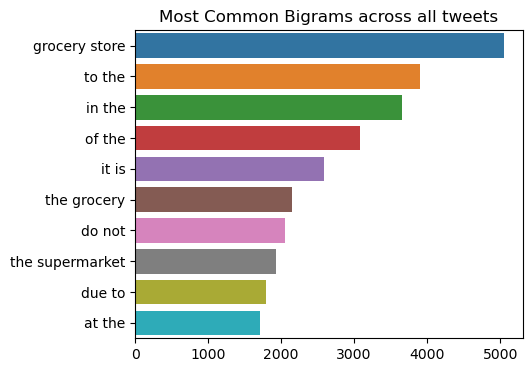

In [51]:
# Top bigrams                               
top_n_bigrams=get_top_ngram(df['filtered_text'],2)[:10]
x,y=map(list,zip(*top_n_bigrams)) 
plt.figure(figsize=(5, 4))
plt.title("Most Common Bigrams across all tweets")
sns.barplot(x=y,y=x)
plt.show()

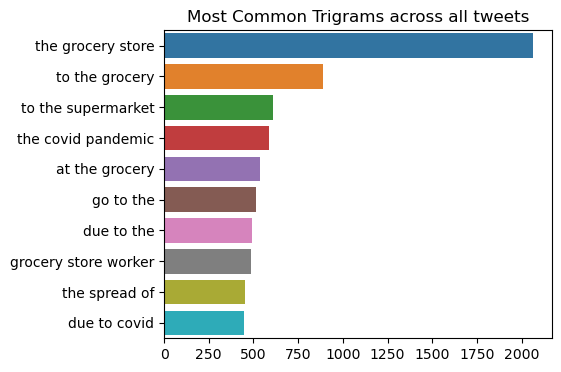

In [52]:
# Top trigrams
top_tri_grams=get_top_ngram(df['filtered_text'],n=3)
x,y=map(list,zip(*top_tri_grams))
plt.figure(figsize=(5, 4))
plt.title("Most Common Trigrams across all tweets")
sns.barplot(x=y,y=x)
plt.show()

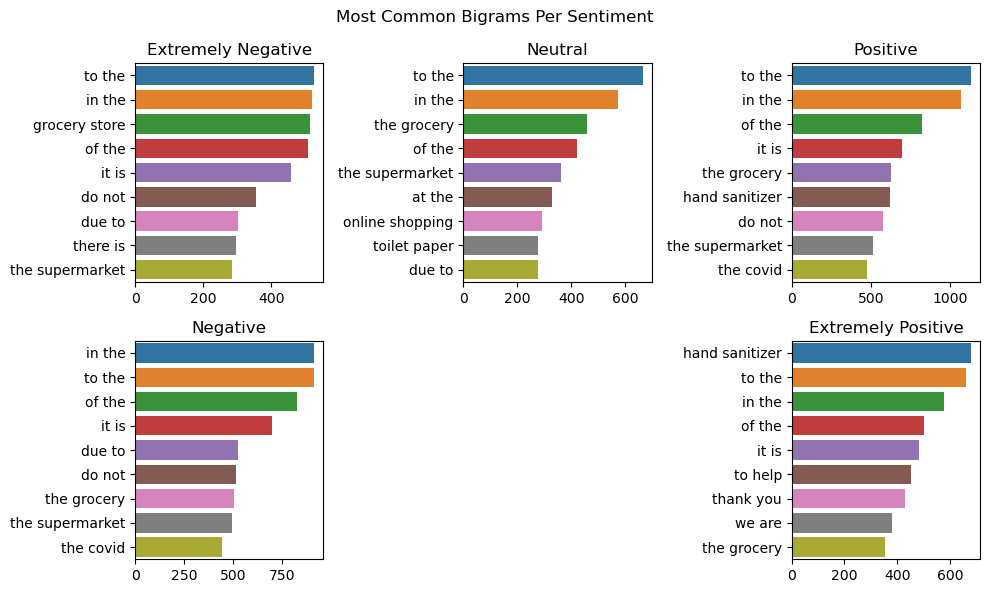

In [53]:
# Do the same by sentiment
x = []
y = []

for s in sentiment_list:
    sub_df = df[df['Sentiment'] == s]
    top_tri_grams = get_top_ngram(sub_df['filtered_text'], n=2)
    x_val, y_val = map(list,zip(*top_tri_grams))
    x.append(x_val)
    y.append(y_val)

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes[1, 1].set_visible(False)

min_r = 1
max_r = 11

sns.barplot(y=x[0][min_r:max_r], x=y[0][min_r:max_r], ax=axes[0, 0])
axes[0, 0].title.set_text(sentiment_list[0])
sns.barplot(y=x[1][min_r:max_r], x=y[1][min_r:max_r], ax=axes[1,0])
axes[1, 0].title.set_text(sentiment_list[1])

sns.barplot(y=x[2][min_r:max_r], x=y[2][min_r:max_r], ax=axes[0,1])
axes[0, 1].title.set_text(sentiment_list[2])

sns.barplot(y=x[3][min_r:max_r], x=y[3][min_r:max_r], ax=axes[0, 2])
axes[0, 2].title.set_text(sentiment_list[3])
sns.barplot(y=x[4][min_r:max_r], x=y[4][min_r:max_r], ax=axes[1,2])
axes[1, 2].title.set_text(sentiment_list[4])

fig.suptitle("Most Common Bigrams Per Sentiment")

plt.tight_layout()   

## WordClouds

### Most Common Words across Every Sentiment

In [54]:
corpus = []
new = df['no_stopwords'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]

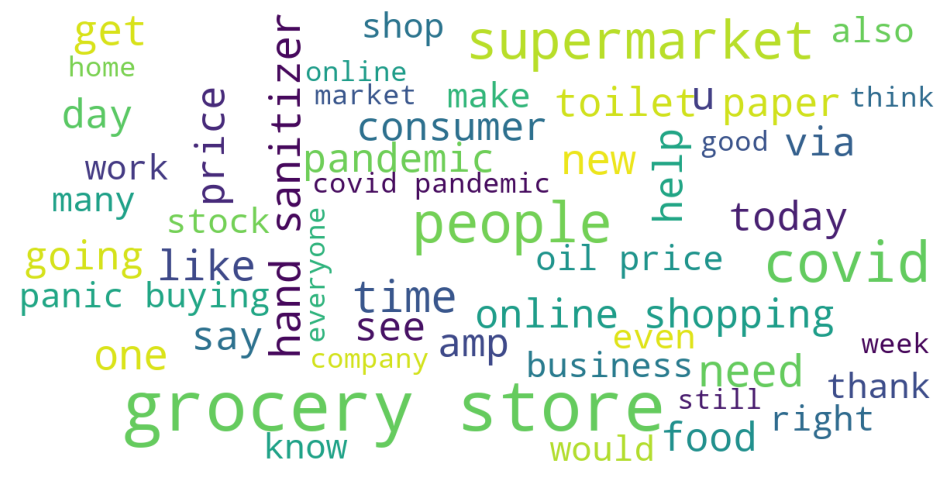

In [55]:
# stopwords = set(STOPWORDS)

def show_wordcloud(data, collocations=True):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop,
        max_words=50,
        max_font_size=30,
        scale=3,
        collocations=collocations,
        random_state=1)
    
    wordcloud = wordcloud.generate(data)
    
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis("off")
    plt.imshow(wordcloud)
    plt.show()
    
flattened = ' '.join(corpus)
show_wordcloud(flattened)

### Most Common Hashtags across Every Sentiment (Excluding Covid)

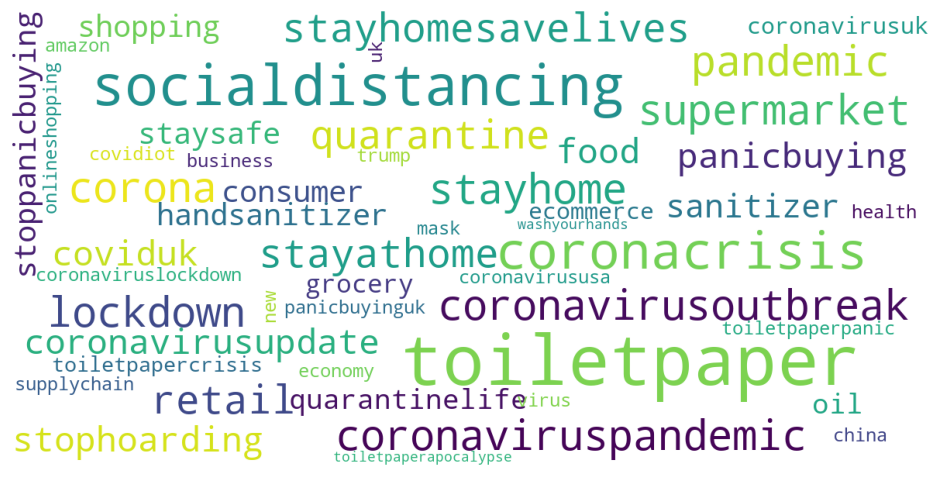

In [56]:
# Hashtags without including covid
hashtags = []
new_hash = df['hashtags'].values.tolist()
hashtags = [word for i in new_hash for word in i]
hashtags_nocovid = list(filter(lambda a: a != 'covid', hashtags))
flat_nocovid = ' '.join(hashtags_nocovid)
show_wordcloud(flat_nocovid, collocations=False)

### Most Common Words by Sentiment

In [57]:
corpus = []
new = df['no_stopwords'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]

In [58]:
def show_wordcloud_by_sentiment(data, collocations=True):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop,
        max_words=50,
        max_font_size=30,
        scale=3,
        collocations=collocations,
        random_state=1)
    
    wordcloud = wordcloud.generate(data)
    return wordcloud

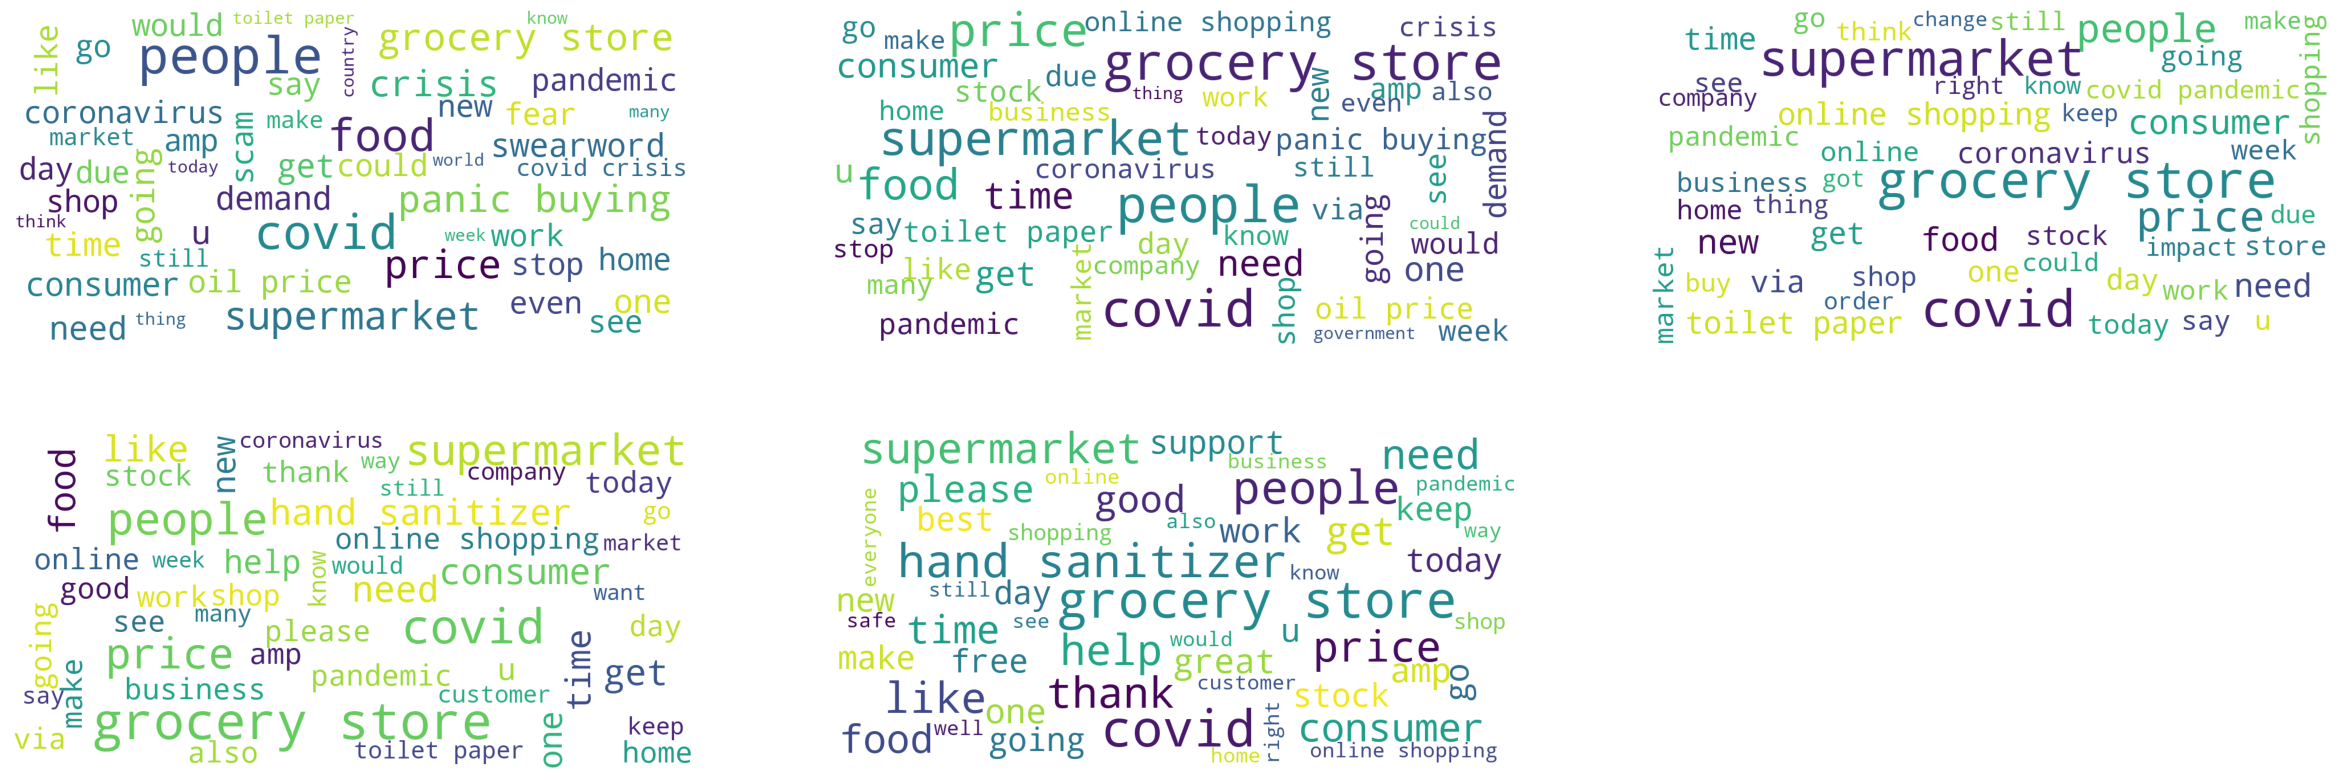

In [59]:
fig = plt.figure(figsize=(30, 10))
i = 0
for sentiment in sentiment_list:
    sub_df = df[df['Sentiment'] == sentiment]
    corp = []
    new_df = sub_df['no_stopwords'].str.split()
    new_df = new_df.values.tolist()
    corp = [word for i in new_df for word in i]
    flat = ' '.join(corp)
    wordcloud = show_wordcloud_by_sentiment(flat)
    ax = fig.add_subplot(2, 3, i + 1)
    ax.imshow(wordcloud)
    ax.axis("off")
    i += 1

### Most Common Hashtags by Sentiment

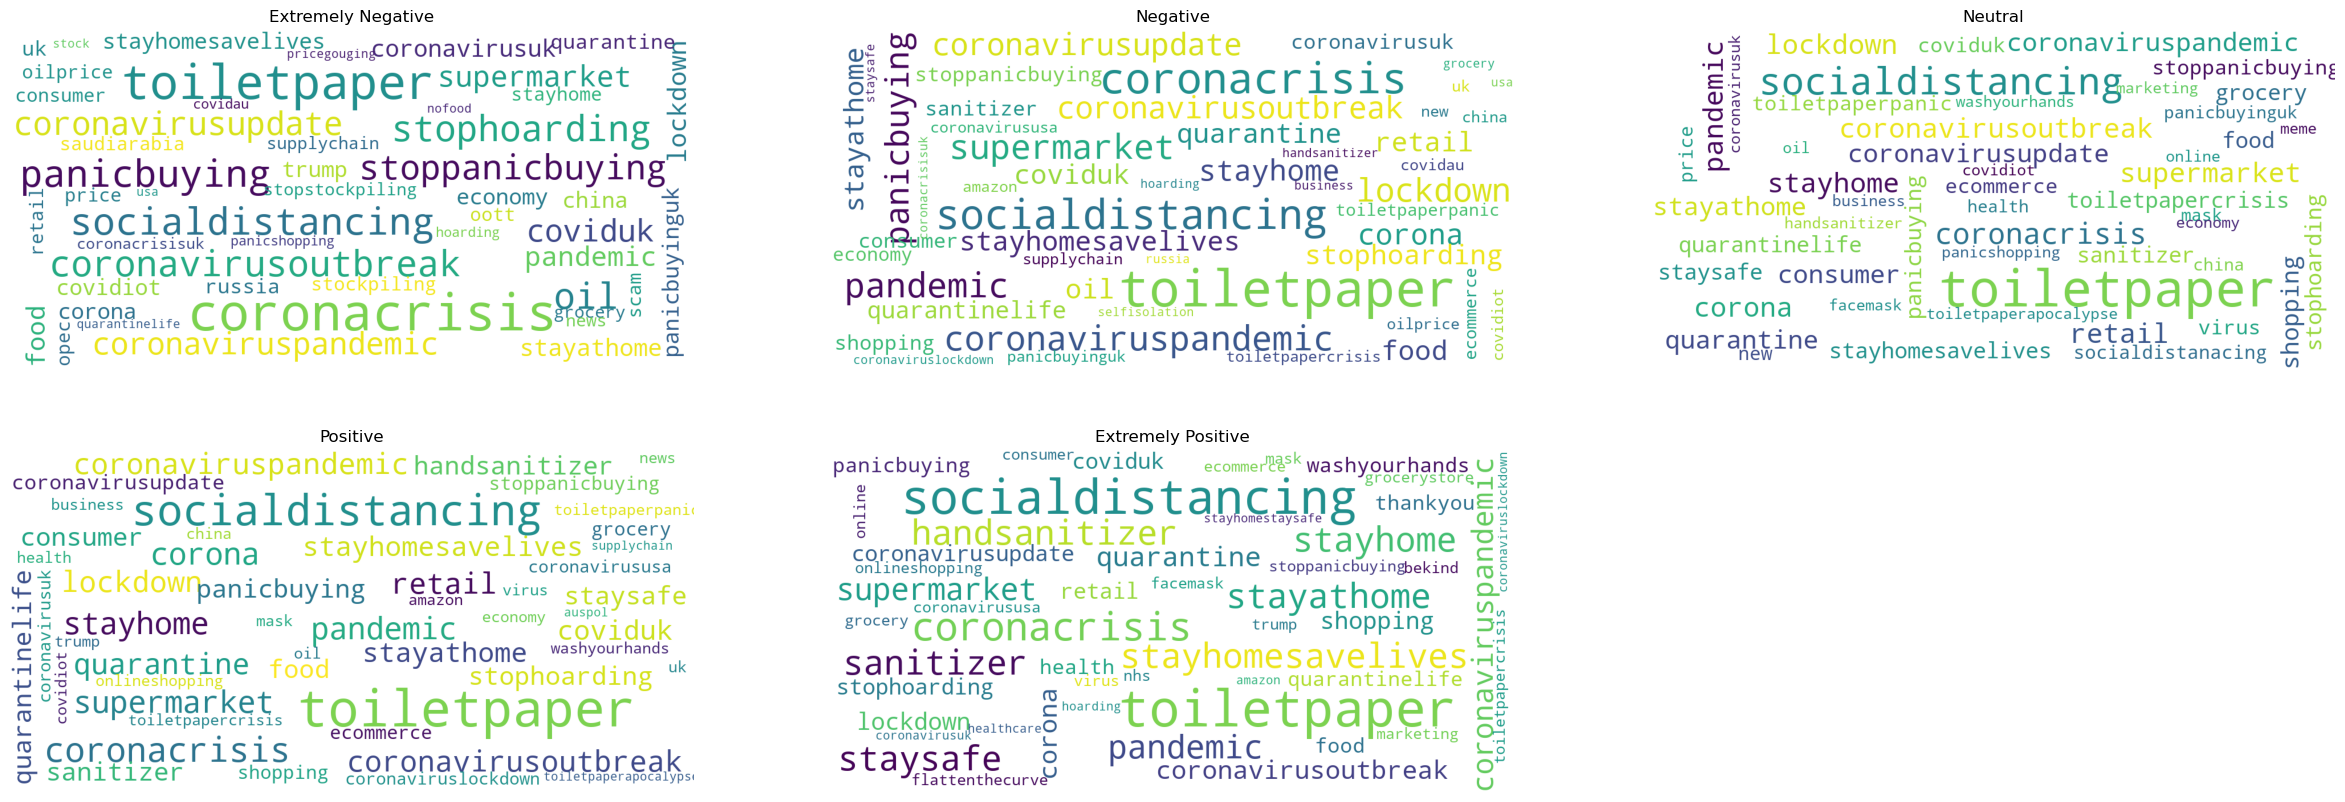

In [60]:
fig = plt.figure(figsize=(30, 10))
i = 0
for sentiment in sentiment_list:
    sub_df = df[df['Sentiment'] == sentiment]
    corp = []
    new_df = sub_df['hashtags'].values.tolist()
    corp = [word for i in new_df for word in i]
    hashtags_nocovid = list(filter(lambda a: a != 'covid', corp))
    flat_nocovid = ' '.join(hashtags_nocovid)
    wordcloud = show_wordcloud_by_sentiment(flat_nocovid, collocations=False)
    ax = fig.add_subplot(2, 3, i + 1)
    ax.imshow(wordcloud)
    ax.axis("off")
    ax.set_title(sentiment)
    i += 1